In [4]:
# -*- coding: utf-8 -*-
"""
consolidar_embargos_clean.py
Lectura robusta de múltiples CSVs 'consulta detalle embargos-*.csv',
normalización de campos (ciudad, entidad_bancaria, tipo_embargo, etc.),
detección de nombres en 'ciudad', corrección de filas con comas en direcciones,
agrupamiento de categorías raras y salida de:
 - embargos_consolidado_mensual_full.csv  (todo)
 - embargos_consolidado_mensual_sample.csv (muestreo por mes)
 - limpieza_resumen.txt (log resumido)
"""

import csv
import glob
import re
from collections import Counter, defaultdict
from pathlib import Path

import pandas as pd
import numpy as np
from unidecode import unidecode

# ---------------------------
# Config
# ---------------------------
INPUT_GLOB = "consulta detalle embargos-*.csv"
EXPECTED_COLUMNS = [
    "id", "ciudad", "entidad_remitente", "correo", "direccion", "funcionario", "fecha_banco",
    "fecha_oficio", "referencia", "cuenta", "identificacion", "tipo_identificacion_tipo", "montoaembargar",
    "nombres", "expediente", "mes", "entidad_bancaria", "estado_embargo", "tipo_documento",
    "tipo_embargo", "estado_demandado", "es_cliente", "tipo_carta"
]
OUTPUT_FULL = "embargos_consolidado_mensual_full.csv"
OUTPUT_SAMPLE = "embargos_consolidado_mensual_sample.csv"
LOG_FILE = "limpieza_resumen.txt"
SAMPLE_FRAC = 0.07
RARE_THRESHOLD = 10  # menos de esto -> 'OTRO'
RANDOM_STATE = 42

# ---------------------------
# Catálogos / heurísticas
# ---------------------------
# Bancos comunes (normalizados)
BANK_KEYS = {
    "BANCOLÓMBIA": "BANCOLÓMBIA", "BANCOLCOLUMBIA": "BANCOLÓMBIA", "BANCOL": "BANCOLÓMBIA",
    "DAVIVIENDA": "DAVIVIENDA",
    "BBVA": "BBVA",
    "BANCO DE BOGOTÁ": "BANCO DE BOGOTÁ", "BANCO DE BOGOTA": "BANCO DE BOGOTÁ",
    "BANCO AGRARIO": "BANCO AGRARIO", "BANCO POPULAR": "BANCO POPULAR", "BANCOLOMBIA": "BANCOLÓMBIA",
    "BANCO OCCIDENTE": "BANCO DE OCCIDENTE", "BCO DE OCCIDENTE": "BANCO DE OCCIDENTE",
    "SCOTIABANK": "SCOTIABANK COLPATRIA", "SCOTIABANK COLPATRIA": "SCOTIABANK COLPATRIA",
    "ITAU": "ITAÚ",
    "AV VILLAS": "AV VILLAS", "AVVILLAS": "AV VILLAS",
    "BANCOLOMBIA S.A.": "BANCOLÓMBIA"
}
BANK_NORMALIZED_SET = set(BANK_KEYS.keys()) | set(BANK_KEYS.values())

# variantes Bogotá
BOGOTA_KEYS = {
    "BOGOTA", "BOGOTÁ", "BOGOTA D.C.", "BOGOTÁ D.C.", "SANTA FE DE BOGOTA", "SANTA FE DE BOGOTÁ",
    "BOGOTA DC", "BOGOTADC", "BOGOTA D C"
}
BOGOTA_CANON = "BOGOTÁ D.C."

# Regex heurística para detectar 'NOMBRE APELLIDO' en ciudad (antes de normalizar)
PERSON_NAME_RE = re.compile(r"^[A-Za-zÁÉÍÓÚÑáéíóúñ]+(?:\s+[A-Za-zÁÉÍÓÚÑáéíóúñ]+){1,3}$")

# ---------------------------
# Funciones auxiliares
# ---------------------------
def normalize_text(s: str) -> str:
    if pd.isna(s):
        return ""
    t = str(s).strip()
    t = unidecode(t)  # quita acentos
    t = re.sub(r"\s+", " ", t)
    return t.upper()

def is_person_name(raw_val: str) -> bool:
    if raw_val is None:
        return False
    v = str(raw_val).strip()
    # Excluir si tiene coma, dígitos, @ (email), barra, punto etc.
    if any(ch in v for ch in [",", "@", "/", ".", "#", "http"]):
        return False
    # Heurística: dos o tres palabras simples -> posible nombre
    return bool(PERSON_NAME_RE.match(v))

def normalize_bank(val: str):
    if not val or pd.isna(val):
        return ""
    cand = normalize_text(val)
    # detecta si contiene alguno de los keys o values
    for k in BANK_NORMALIZED_SET:
        if k in cand:
            return BANK_KEYS.get(k, k)
    # último recurso: token match
    for tok in BANK_NORMALIZED_SET:
        if tok in cand:
            return BANK_KEYS.get(tok, tok)
    return cand

def repair_row_columns(row: list, expected_len: int) -> (list, str):
    """
    Repara filas con diferente número de columnas.
    Si hay más columnas, junta extras en 'direccion' (índice 4).
    Si faltan, pad con ''.
    Devuelve (fixed_row, status) donde status in {'ok','pad','merged','bad'}
    """
    if len(row) == expected_len:
        return row, "ok"
    if len(row) < expected_len:
        # pad right
        new = row + [""] * (expected_len - len(row))
        return new, "pad"
    # len(row) > expected_len: intentar unir columnas extras a 'direccion' (índice 4)
    extra = len(row) - expected_len
    # join from 4 to 4+extra inclusive
    try:
        direccion = row[4: 4 + 1 + extra]
        direccion_joined = ",".join(direccion)
        fixed = row[:4] + [direccion_joined] + row[4 + 1 + extra:]
        if len(fixed) == expected_len:
            return fixed, "merged"
    except Exception:
        pass
    return row, "bad"

# ---------------------------
# Lectura robusta de archivos
# ---------------------------
files = sorted(glob.glob(INPUT_GLOB))
if not files:
    raise FileNotFoundError(f"No se encontraron archivos con patrón: {INPUT_GLOB}")

rows_all = []
log_corregidas = []
log_omitidas = []

for fpath in files:
    print(f"→ Procesando {fpath} ...")
    with open(fpath, encoding="utf-8", errors="replace", newline="") as fh:
        reader = csv.reader(fh, delimiter=",", quotechar='"')
        try:
            header = next(reader)
        except StopIteration:
            continue
        # Normalize header: si no coincide exactamente, intentamos mapear por posición
        # asumimos que el orden real es el esperado; si header coincide con EXPECTED_COLUMNS, usamos eso.
        header_norm = [normalize_text(h) for h in header]
        use_expected = False
        if len(header) == len(EXPECTED_COLUMNS):
            # si nombres difieren, igual hacemos asignación por posición
            use_expected = True
        # leemos fila por fila y reparamos
        for i, row in enumerate(reader, start=2):
            fixed, status = repair_row_columns(row, len(EXPECTED_COLUMNS))
            if status == "bad":
                log_omitidas.append((fpath, i, len(row)))
                continue
            if status in ("pad", "merged"):
                log_corregidas.append((fpath, i, status))
            rows_all.append(fixed)

# Crear DataFrame
df = pd.DataFrame(rows_all, columns=EXPECTED_COLUMNS)
print(f"Filas leídas: {len(df)} (archivos: {len(files)})")

# ---------------------------
# Limpieza básica y normalización
# ---------------------------
# 1) numéricos
df['montoaembargar'] = pd.to_numeric(df['montoaembargar'], errors='coerce').fillna(0.0)
# id como entero si aplica
df['id'] = pd.to_numeric(df['id'], errors='coerce').fillna(method='ffill').astype(int, errors='ignore')

# 2) fechas
for c in ['fecha_banco', 'fecha_oficio', 'mes']:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

# 3) es_cliente
if 'es_cliente' in df.columns:
    df['es_cliente'] = df['es_cliente'].apply(lambda v: 1 if str(v).strip().upper() in {'1','SI','SÍ','YES','CLIENTE','TRUE','Y'} else 0).astype(int)

# 4) Normalizar texto en columnas clave (pero mantenemos raw para heurísticas)
for col in ['ciudad', 'entidad_bancaria', 'entidad_remitente', 'tipo_embargo', 'estado_embargo', 'tipo_documento', 'estado_demandado', 'tipo_carta']:
    if col in df.columns:
        df[col] = df[col].astype(str).fillna('').map(lambda x: str(x).strip())

# ---------------------------
# 5) Detectar y limpiar 'ciudad' con nombres de personas
# ---------------------------
# Usamos la versión cruda antes de normalizar
ciudad_raw = df['ciudad'].astype(str).copy()
person_mask = ciudad_raw.apply(lambda v: is_person_name(v))
n_personas_detectadas = int(person_mask.sum())
df.loc[person_mask, 'ciudad'] = ""  # borramos el valor sospechoso para que quede vacío y se pueda revisar

# ---------------------------
# 6) Normalizar y unificar Bogotá y bancos; corregir bancos en tipo_embargo
# ---------------------------
# Normalize cities: remove accents, upper, unify Bogotá
df['ciudad_norm'] = df['ciudad'].map(lambda x: normalize_text(x))
df['entidad_bancaria_norm'] = df['entidad_bancaria'].map(lambda x: normalize_text(x))
df['tipo_embargo_norm'] = df['tipo_embargo'].map(lambda x: normalize_text(x))

# Bogotá canonical
df.loc[df['ciudad_norm'].isin({normalize_text(x) for x in BOGOTA_KEYS}), 'ciudad'] = BOGOTA_CANON
# also if ciudad blank but entidad contains 'BOGOTA' -> set Bogotá
mask_ciudad_blank = df['ciudad'].map(lambda s: str(s).strip() == "")
mask_ent_contains_bog = df['entidad_remitente'].map(lambda s: normalize_text(s)).str.contains("BOGOTA", na=False)
df.loc[mask_ciudad_blank & mask_ent_contains_bog, 'ciudad'] = BOGOTA_CANON

# Normalize banks: if tipo_embargo contains a bank name → move to entidad_bancaria
def move_bank_if_in_tipo(row):
    tipo = normalize_text(row.get('tipo_embargo', ''))
    ent = normalize_text(row.get('entidad_bancaria', ''))
    # si en tipo aparece un banco conocido, lo movemos
    for bk in BANK_NORMALIZED_SET:
        if bk in tipo:
            # poner en entidad_bancaria (si no tiene), y fijar tipo_embargo a 'CUENTA BANCARIA'
            row['entidad_bancaria'] = BANK_KEYS.get(bk, bk)
            row['tipo_embargo'] = 'Cuenta bancaria'
            return row
    # si entidad_bancaria parece banco pero está en otro campo (ej. entidad_remitente)
    # no cambiamos aquí
    return row

df = df.apply(move_bank_if_in_tipo, axis=1)

# Unificar entidad_bancaria a nombres canónicos (por heurística substring)
def canonicalize_bank(val):
    v = normalize_text(val)
    if not v:
        return ""
    # check keys
    for k, canon in BANK_KEYS.items():
        if k in v or canon in v:
            return canon
    # fallback: return upper stripped
    return v

df['entidad_bancaria'] = df['entidad_bancaria'].fillna('').map(canonicalize_bank)

# 7) Agrupar categorías raras
for col in ['tipo_embargo', 'estado_embargo', 'estado_demandado']:
    if col in df.columns:
        vc = df[col].astype(str).value_counts()
        rares = vc[vc < RARE_THRESHOLD].index.tolist()
        df.loc[df[col].isin(rares), col] = 'OTRO'

# 8) Arreglar ciudad vacía por persona detectada -> dejar NaN y luego agrupar raros
df['ciudad'] = df['ciudad'].astype(str).replace({"": np.nan, "NAN": np.nan, "NONE": np.nan})
if 'ciudad' in df.columns:
    vc_city = df['ciudad'].dropna().value_counts()
    rares_city = vc_city[vc_city < RARE_THRESHOLD].index.tolist()
    df.loc[df['ciudad'].isin(rares_city), 'ciudad'] = 'OTRO'
    # finalmente normalizamos el casing de ciudad (todo mayúsculas con acentos recuperados si se desea)
    df['ciudad'] = df['ciudad'].fillna('OTRO').map(lambda x: normalize_text(x))

# 9) Estandarizar 'mes' a YYYY-MM si existe
if 'mes' in df.columns:
    df['mes'] = pd.to_datetime(df['mes'], errors='coerce').dt.to_period('M').dt.to_timestamp()
else:
    df['mes'] = pd.NaT

# ---------------------------
# 10) Resúmenes y guardado
# ---------------------------
Path(".").mkdir(parents=True, exist_ok=True)

# Guardar full consolidated (sin muestreo)
df.to_csv(OUTPUT_FULL, index=False, encoding='utf-8')
# Muestreo estratificado por mes (mantiene representatividad temporal)
if df['mes'].notna().any():
    try:
        df_sample = df.groupby('mes', group_keys=False).apply(
            lambda x: x.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE) if len(x) > 1 else x
        ).reset_index(drop=True)
    except Exception:
        df_sample = df.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE).reset_index(drop=True)
else:
    df_sample = df.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE).reset_index(drop=True)

df_sample.to_csv(OUTPUT_SAMPLE, index=False, encoding='utf-8')

# ---------------------------
# 11) Informe de limpieza
# ---------------------------
with open(LOG_FILE, "w", encoding="utf-8") as logf:
    logf.write("Resumen limpieza embargos\n")
    logf.write("=========================\n\n")
    logf.write(f"Archivos leídos: {len(files)}\n")
    logf.write(f"Filas leídas totales: {len(rows_all)}\n")
    logf.write(f"Filas finales (full): {len(df)}\n")
    logf.write(f"Filas muestra (frac={SAMPLE_FRAC}): {len(df_sample)}\n\n")
    logf.write(f"Filas corregidas (pad/merged): {len(log_corregidas)}\n")
    logf.write(f"Filas omitidas (bad): {len(log_omitidas)}\n\n")
    logf.write(f"Personas detectadas en 'ciudad' (borradas): {n_personas_detectadas}\n\n")
    # Top valores por columna clave (antes/después sería ideal; aquí mostramos después)
    for c in ['ciudad', 'entidad_bancaria', 'tipo_embargo', 'estado_embargo']:
        if c in df.columns:
            logf.write(f"Top 10 {c} (post-clean):\n")
            for v, cnt in df[c].value_counts().head(10).items():
                logf.write(f"  {v} : {cnt}\n")
            logf.write("\n")
print("Limpieza finalizada. Archivos generados:")
print(" -", OUTPUT_FULL)
print(" -", OUTPUT_SAMPLE)
print(" -", LOG_FILE)


→ Procesando consulta detalle embargos-2023-01.csv ...
→ Procesando consulta detalle embargos-2023-02.csv ...
→ Procesando consulta detalle embargos-2024-01.csv ...
→ Procesando consulta detalle embargos-2024-02.csv ...
Filas leídas: 2227458 (archivos: 4)


C:\Users\JuanM\AppData\Local\Temp\ipykernel_2852\3351112938.py:175: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['id'] = pd.to_numeric(df['id'], errors='coerce').fillna(method='ffill').astype(int, errors='ignore')
C:\Users\JuanM\AppData\Local\Temp\ipykernel_2852\3351112938.py:278: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('mes', group_keys=False).apply(


Limpieza finalizada. Archivos generados:
 - embargos_consolidado_mensual_full.csv
 - embargos_consolidado_mensual_sample.csv
 - limpieza_resumen.txt


=== REGRESIÓN: Oficios por mes ===
RMSE: 2623.5102439289235
MAE: 1848.95458984375
Promedio real: 9564.444444444445


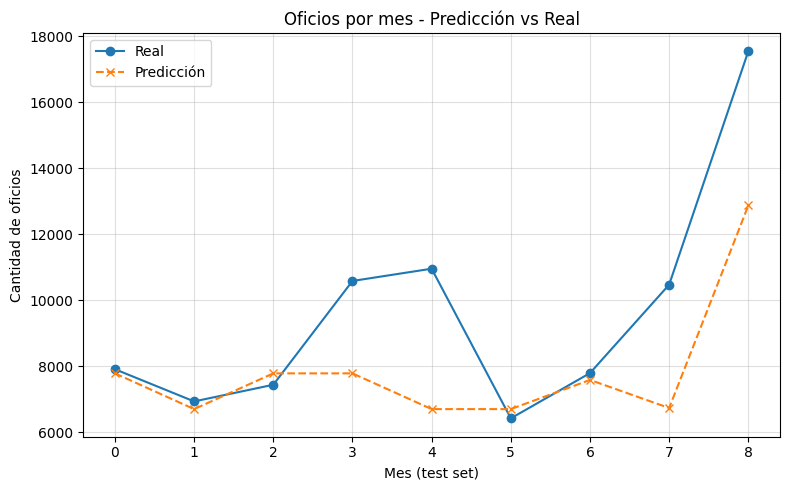


=== REGRESIÓN: Demandados únicos por mes ===
RMSE: 2436.5822374793756
MAE: 1742.0723876953125
Promedio real: 8761.555555555555


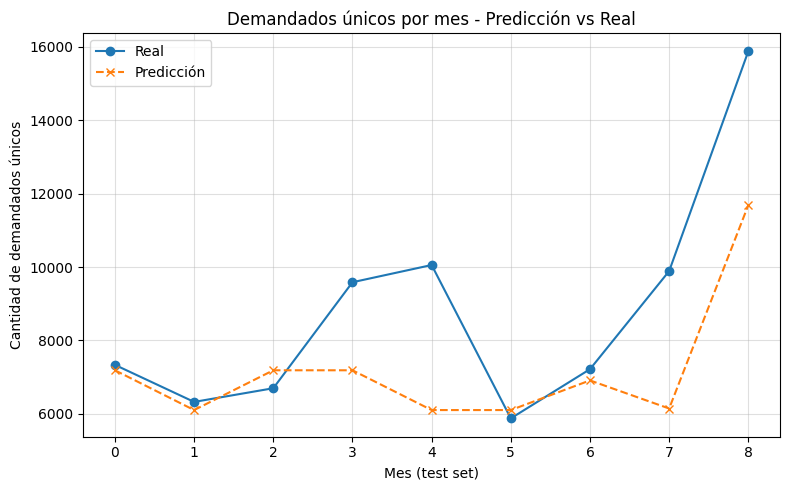


=== CLASIFICACIÓN: Tipo de embargo ===
              precision    recall  f1-score   support

    COACTIVO       0.99      0.97      0.98     22680
    JUDICIAL       0.91      0.98      0.94      8260

    accuracy                           0.97     30940
   macro avg       0.95      0.97      0.96     30940
weighted avg       0.97      0.97      0.97     30940


=== CLASIFICACIÓN: Estado de oficio ===
                       precision    recall  f1-score   support

           CONFIRMADO       0.78      0.78      0.78     15989
            PROCESADO       0.76      0.76      0.76     14948
PROCESADO_CON_ERRORES       0.00      0.00      0.00         3

             accuracy                           0.77     30940
            macro avg       0.51      0.51      0.51     30940
         weighted avg       0.77      0.77      0.77     30940


=== CLASIFICACIÓN: Cliente o no cliente ===
              precision    recall  f1-score   support

  NO_CLIENTE       0.99      0.87      0.92     

In [16]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import json

from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# ===================== CONFIG =====================
CSV_PATH = "embargos_consolidado_mensual_sample.csv"
OUT_DIR = Path("modelos_pkl")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ===================== CARGA Y LIMPIEZA DE DATOS =====================
df = pd.read_csv(CSV_PATH, encoding="utf-8", low_memory=False)

def agrupar_otros(df, col, min_freq=10):
    freq = df[col].value_counts()
    otros = freq[freq < min_freq].index
    df[col] = df[col].apply(lambda x: 'OTRO' if x in otros else x)
    return df

# Normaliza y agrupa raros (por si se cuela algo)
for col in ['ciudad', 'entidad_remitente', 'tipo_embargo', 'estado_embargo']:
    if col not in df.columns:
        df[col] = 'OTRO'
    df[col] = df[col].fillna('OTRO').astype(str).str.strip().str.upper()
    df = agrupar_otros(df, col, min_freq=10)

# Monto
if 'montoaembargar' in df.columns:
    df['montoaembargar'] = pd.to_numeric(df['montoaembargar'], errors='coerce').fillna(0.0)
else:
    df['montoaembargar'] = 0.0

# Cliente binario
def clean_cliente(val):
    v = str(val).strip().upper()
    return 1 if v in {'1', 'SI', 'SI_ES_CLIENTE', 'CLIENTE', 'TRUE', 'SÍ', 'YES', 'Y'} else 0
df['es_cliente_bin'] = df.get('es_cliente', 0)
df['es_cliente_bin'] = df['es_cliente_bin'].apply(clean_cliente).astype(int)

# Fechas -> año/mes
df['fecha_banco'] = pd.to_datetime(df.get('fecha_banco', pd.NaT), errors='coerce')
df['año'] = pd.to_numeric(df['fecha_banco'].dt.year, errors='coerce')
df['mes_num'] = pd.to_numeric(df['fecha_banco'].dt.month, errors='coerce')
df = df.dropna(subset=['año', 'mes_num']).copy()
df['año'] = df['año'].astype(int)
df['mes_num'] = df['mes_num'].astype(int)

# Encoders (reutilizables)
le_ciudad = LabelEncoder()
le_entidad = LabelEncoder()
le_tipo_embargo = LabelEncoder()
le_estado_embargo = LabelEncoder()

df['ciudad_enc'] = le_ciudad.fit_transform(df['ciudad'])
df['entidad_remitente_enc'] = le_entidad.fit_transform(df['entidad_remitente'])
df['tipo_embargo_enc'] = le_tipo_embargo.fit_transform(df['tipo_embargo'])
df['estado_embargo_enc'] = le_estado_embargo.fit_transform(df['estado_embargo'])

# Estacionalidad y mes índice
df['mes_sin'] = np.sin(2 * np.pi * df['mes_num'] / 12.0)
df['mes_cos'] = np.cos(2 * np.pi * df['mes_num'] / 12.0)
df['mes_index'] = df['año'] * 12 + df['mes_num']

# ===================== REGRESIONES MENSUALES =====================
# Agregado por mes
if 'id' not in df.columns:
    df['id'] = 0
if 'identificacion' not in df.columns:
    df['identificacion'] = ""

oficios_por_mes = (
    df.groupby(['año','mes_num'])
      .agg(id=('id','count'),
           identificacion=('identificacion', pd.Series.nunique),
           montoaembargar=('montoaembargar','sum'))
      .reset_index()
      .sort_values(['año','mes_num'])
      .copy()
)

# Lags / medias móviles
oficios_por_mes['oficios_lag1'] = oficios_por_mes['id'].shift(1)
oficios_por_mes['oficios_lag2'] = oficios_por_mes['id'].shift(2)
oficios_por_mes['oficios_lag3'] = oficios_por_mes['id'].shift(3)
oficios_por_mes['oficios_ma3']  = oficios_por_mes['id'].rolling(window=3).mean().shift(1)

oficios_por_mes['demandados_lag1'] = oficios_por_mes['identificacion'].shift(1)
oficios_por_mes['demandados_lag2'] = oficios_por_mes['identificacion'].shift(2)
oficios_por_mes['demandados_ma3']  = oficios_por_mes['identificacion'].rolling(window=3).mean().shift(1)

oficios_por_mes['mes_sin'] = np.sin(2 * np.pi * oficios_por_mes['mes_num'] / 12.0)
oficios_por_mes['mes_cos'] = np.cos(2 * np.pi * oficios_por_mes['mes_num'] / 12.0)

# Validación temporal (último año = test)
ultimo_año = int(oficios_por_mes['año'].max())
train = oficios_por_mes[oficios_por_mes['año'] < ultimo_año].copy()
test  = oficios_por_mes[oficios_por_mes['año'] == ultimo_año].copy()

# ---------- REGRESIÓN: Oficios por mes ----------
features_reg = ['año','mes_num','mes_sin','mes_cos','oficios_lag1','oficios_lag2','oficios_lag3','oficios_ma3']
X_train = train[features_reg]; y_train = train['id']
X_test  = test[features_reg];  y_test  = test['id']

mask_train = ~(X_train.isnull().any(axis=1) | y_train.isnull())
mask_test  = ~(X_test.isnull().any(axis=1)  | y_test.isnull())
X_train_clean, y_train_clean = X_train[mask_train], y_train[mask_train]
X_test_clean,  y_test_clean  = X_test[mask_test],  y_test[mask_test]

regressor = XGBRegressor(
    n_estimators=200, learning_rate=0.1, max_depth=7,
    objective='count:poisson', random_state=42, tree_method="hist"
)
regressor.fit(X_train_clean, y_train_clean)
y_pred = regressor.predict(X_test_clean)

print("=== REGRESIÓN: Oficios por mes ===")
print("RMSE:", np.sqrt(mean_squared_error(y_test_clean, y_pred)))
print("MAE:", mean_absolute_error(y_test_clean, y_pred))
print("Promedio real:", y_test_clean.mean())

# Guardar modelo
joblib.dump(regressor, OUT_DIR / "reg_oficios_xgb_poisson.pkl")

plt.figure(figsize=(8,5))
plt.plot(range(len(y_test_clean)), y_test_clean.values, 'o-', label='Real')
plt.plot(range(len(y_pred)), y_pred, 'x--', label='Predicción')
plt.title("Oficios por mes - Predicción vs Real")
plt.xlabel("Mes (test set)")
plt.ylabel("Cantidad de oficios")
plt.legend(); plt.grid(True, alpha=0.4); plt.tight_layout(); plt.show()

# ---------- REGRESIÓN: Demandados únicos por mes ----------
features_dem = ['año','mes_num','mes_sin','mes_cos','demandados_lag1','demandados_lag2','demandados_ma3']
X_train_d = train[features_dem]; y_train_d = train['identificacion']
X_test_d  = test[features_dem];  y_test_d  = test['identificacion']

mask_train_d = ~(X_train_d.isnull().any(axis=1) | y_train_d.isnull())
mask_test_d  = ~(X_test_d.isnull().any(axis=1)  | y_test_d.isnull())
X_train_d_clean, y_train_d_clean = X_train_d[mask_train_d], y_train_d[mask_train_d]
X_test_d_clean,  y_test_d_clean  = X_test_d[mask_test_d],  y_test_d[mask_test_d]

regressor_dem = XGBRegressor(
    n_estimators=200, learning_rate=0.1, max_depth=7,
    objective='count:poisson', random_state=42, tree_method="hist"
)
regressor_dem.fit(X_train_d_clean, y_train_d_clean)
y_pred_d = regressor_dem.predict(X_test_d_clean)

print("\n=== REGRESIÓN: Demandados únicos por mes ===")
print("RMSE:", np.sqrt(mean_squared_error(y_test_d_clean, y_pred_d)))
print("MAE:", mean_absolute_error(y_test_d_clean, y_pred_d))
print("Promedio real:", y_test_d_clean.mean())

# Guardar modelo
joblib.dump(regressor_dem, OUT_DIR / "reg_demandados_xgb_poisson.pkl")

plt.figure(figsize=(8,5))
plt.plot(range(len(y_test_d_clean)), y_test_d_clean.values, 'o-', label='Real')
plt.plot(range(len(y_pred_d)), y_pred_d, 'x--', label='Predicción')
plt.title("Demandados únicos por mes - Predicción vs Real")
plt.xlabel("Mes (test set)")
plt.ylabel("Cantidad de demandados únicos")
plt.legend(); plt.grid(True, alpha=0.4); plt.tight_layout(); plt.show()

# ===================== CLASIFICACIONES =====================
def filtrar_para_stratify(X, y, min_por_clase=2):
    vc = y.value_counts()
    clases_ok = vc[vc >= min_por_clase].index
    m = y.isin(clases_ok)
    return X[m], y[m]

# Variables para clasificación (num + categ codificadas)
features_clf = [
    'entidad_remitente_enc', 'mes_num', 'montoaembargar',
    'estado_embargo_enc', 'es_cliente_bin'
]

# --- 1) Tipo de embargo (ej. COACTIVO/JUDICIAL/OTRO) ---
X = df[features_clf]
y = df['tipo_embargo_enc']
X, y = filtrar_para_stratify(X, y, min_por_clase=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
clf = XGBClassifier(
    n_estimators=100, max_depth=7, learning_rate=0.1,
    subsample=0.9, colsample_bytree=0.8,
    eval_metric='mlogloss', tree_method="hist", random_state=42
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
labels_report = np.unique(np.concatenate([y_test, y_pred]))
print("\n=== CLASIFICACIÓN: Tipo de embargo ===")
print(classification_report(
    y_test, y_pred,
    labels=labels_report,
    target_names=le_tipo_embargo.inverse_transform(labels_report),
    zero_division=0
))

# Guardar modelo
joblib.dump(clf, OUT_DIR / "clf_tipo_embargo_xgb.pkl")

# --- 2) Estado de oficio (embargo, desembargo, requerimientos, ...) ---
features_clf2 = [
    'entidad_remitente_enc', 'mes_num', 'montoaembargar',
    'tipo_embargo_enc', 'es_cliente_bin'
]
X2 = df[features_clf2]
y2 = df['estado_embargo_enc']
X2, y2 = filtrar_para_stratify(X2, y2, min_por_clase=2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify=y2, test_size=0.2, random_state=42)
clf2 = XGBClassifier(
    n_estimators=100, max_depth=7, learning_rate=0.1,
    subsample=0.9, colsample_bytree=0.8,
    eval_metric='mlogloss', tree_method="hist", random_state=42
)
clf2.fit(X_train2, y_train2)
y_pred2 = clf2.predict(X_test2)
labels_report2 = np.unique(np.concatenate([y_test2, y_pred2]))
print("\n=== CLASIFICACIÓN: Estado de oficio ===")
print(classification_report(
    y_test2, y_pred2,
    labels=labels_report2,
    target_names=le_estado_embargo.inverse_transform(labels_report2),
    zero_division=0
))

# Guardar modelo
joblib.dump(clf2, OUT_DIR / "clf_estado_embargo_xgb.pkl")

# --- 3) Cliente o no cliente ---
features_clf3 = [
    'entidad_remitente_enc', 'mes_num', 'montoaembargar',
    'tipo_embargo_enc', 'estado_embargo_enc'
]
X3 = df[features_clf3]
y3 = df['es_cliente_bin'].astype(int)
if y3.nunique() < 2:
    print("\n=== CLASIFICACIÓN: Cliente o no cliente ===")
    print("Solo hay una clase en es_cliente_bin. Se omite este modelo.")
    clf3 = None
else:
    X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, stratify=y3, test_size=0.2, random_state=42)
    pos = (y_train3 == 1).sum(); neg = (y_train3 == 0).sum()
    spw = float(neg/pos) if pos > 0 else 1.0
    clf3 = XGBClassifier(
        n_estimators=100, max_depth=7, learning_rate=0.1,
        subsample=0.9, colsample_bytree=0.8,
        eval_metric='auc', tree_method="hist", random_state=42,
        scale_pos_weight=spw
    )
    clf3.fit(X_train3, y_train3)
    y_pred3 = clf3.predict(X_test3)
    labels_report3 = np.unique(np.concatenate([y_test3, y_pred3]))
    print("\n=== CLASIFICACIÓN: Cliente o no cliente ===")
    print(classification_report(
        y_test3, y_pred3,
        labels=labels_report3,
        target_names=["NO_CLIENTE", "CLIENTE"],
        zero_division=0
    ))
    # Guardar modelo
    joblib.dump(clf3, OUT_DIR / "clf_es_cliente_xgb.pkl")

# --- 4) Ciudad ---
features_for_ciudad = features_clf + ['tipo_embargo_enc']
X4 = df[features_for_ciudad]
y4 = df['ciudad_enc']
X4, y4 = filtrar_para_stratify(X4, y4, min_por_clase=2)
if y4.nunique() < 2:
    print("\n=== CLASIFICACIÓN: Ciudad ===")
    print("Menos de 2 clases tras filtrar. Se omite este modelo.")
    clf4 = None
else:
    X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, stratify=y4, test_size=0.2, random_state=42)
    clf4 = XGBClassifier(
        n_estimators=100, max_depth=7, learning_rate=0.1,
        subsample=0.9, colsample_bytree=0.8,
        eval_metric='mlogloss', tree_method="hist", random_state=42
    )
    clf4.fit(X_train4, y_train4)
    y_pred4 = clf4.predict(X_test4)
    labels_report4 = np.unique(np.concatenate([y_test4, y_pred4]))
    print("\n=== CLASIFICACIÓN: Ciudad ===")
    print(classification_report(
        y_test4, y_pred4,
        labels=labels_report4,
        target_names=le_ciudad.inverse_transform(labels_report4),
        zero_division=0
    ))
    # Guardar modelo
    joblib.dump(clf4, OUT_DIR / "clf_ciudad_xgb.pkl")

# --- 5) Entidad remitente ---
features_for_entidad = features_clf + ['tipo_embargo_enc']
X5 = df[features_for_entidad]
y5 = df['entidad_remitente_enc']
X5, y5 = filtrar_para_stratify(X5, y5, min_por_clase=2)
if y5.nunique() < 2:
    print("\n=== CLASIFICACIÓN: Entidad remitente ===")
    print("Menos de 2 clases tras filtrar. Se omite este modelo.")
    clf5 = None
else:
    X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, stratify=y5, test_size=0.2, random_state=42)
    clf5 = XGBClassifier(
        n_estimators=100, max_depth=7, learning_rate=0.1,
        subsample=0.9, colsample_bytree=0.8,
        eval_metric='mlogloss', tree_method="hist", random_state=42
    )
    clf5.fit(X_train5, y_train5)
    y_pred5 = clf5.predict(X_test5)
    labels_report5 = np.unique(np.concatenate([y_test5, y_pred5]))
    print("\n=== CLASIFICACIÓN: Entidad remitente ===")
    print(classification_report(
        y_test5, y_pred5,
        labels=labels_report5,
        target_names=le_entidad.inverse_transform(labels_report5),
        zero_division=0
    ))
    # Guardar modelo
    joblib.dump(clf5, OUT_DIR / "clf_entidad_remitente_xgb.pkl")

# ===================== GUARDAR ENCODERS Y METADATOS =====================
joblib.dump(le_ciudad, OUT_DIR / "enc_ciudad.pkl")
joblib.dump(le_entidad, OUT_DIR / "enc_entidad_remitente.pkl")
joblib.dump(le_tipo_embargo, OUT_DIR / "enc_tipo_embargo.pkl")
joblib.dump(le_estado_embargo, OUT_DIR / "enc_estado_embargo.pkl")

metadata = {
    "csv_origen": CSV_PATH,
    "modelos": {
        "reg_oficios": "reg_oficios_xgb_poisson.pkl",
        "reg_demandados": "reg_demandados_xgb_poisson.pkl",
        "clf_tipo_embargo": "clf_tipo_embargo_xgb.pkl",
        "clf_estado_embargo": "clf_estado_embargo_xgb.pkl",
        "clf_es_cliente": "clf_es_cliente_xgb.pkl" if 'clf3' in locals() and clf3 is not None else None,
        "clf_ciudad": "clf_ciudad_xgb.pkl" if 'clf4' in locals() and clf4 is not None else None,
        "clf_entidad_remitente": "clf_entidad_remitente_xgb.pkl" if 'clf5' in locals() and clf5 is not None else None,
    },
    "encoders": {
        "ciudad": "enc_ciudad.pkl",
        "entidad_remitente": "enc_entidad_remitente.pkl",
        "tipo_embargo": "enc_tipo_embargo.pkl",
        "estado_embargo": "enc_estado_embargo.pkl"
    },
    "features": {
        "reg_oficios": features_reg,
        "reg_demandados": features_dem,
        "clf_tipo_embargo": features_clf,
        "clf_estado_embargo": ['entidad_remitente_enc','mes_num','montoaembargar','tipo_embargo_enc','es_cliente_bin'],
        "clf_es_cliente": ['entidad_remitente_enc','mes_num','montoaembargar','tipo_embargo_enc','estado_embargo_enc'],
        "clf_ciudad": features_for_ciudad,
        "clf_entidad_remitente": features_for_entidad
    }
}
with open(OUT_DIR / "metadata_modelos.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print(f"\n✅ Modelos y encoders guardados en: {OUT_DIR.resolve()}")
